In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [2]:
import _fig_params

In [3]:
np.random.seed(2)

In [4]:
z = np.linspace(-20, 20, 200)
rho = np.zeros_like(z)
rho[np.where(z >= 0)] = 2.074e-6

In [5]:
rho_dash = np.zeros_like(z)
z_dash = np.append(z, 0)
rho_dash = np.append(rho_dash, 2.074e-6)
sort = np.argsort(z_dash)
z_dash = z_dash[sort]
rho_dash = rho_dash[sort]

In [6]:
q = np.linspace(0.002, 0.05, 500)
r = 16 * np.pi ** 2 * 2.074e-6 ** 2 / (q ** 4)

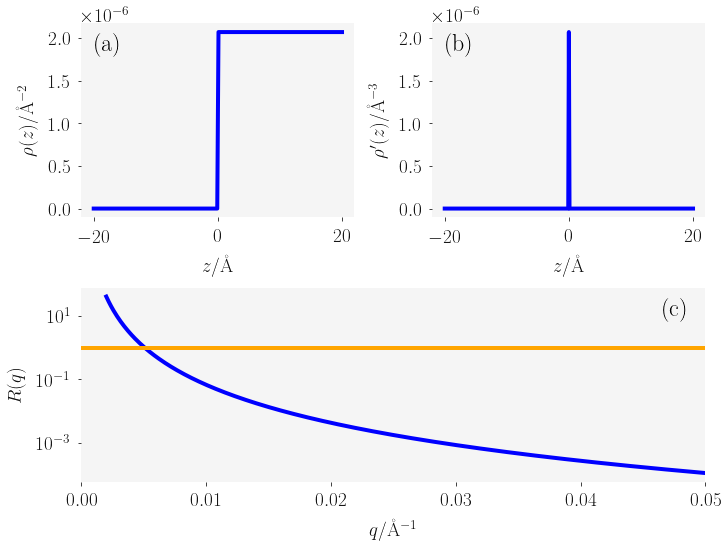

In [7]:
fig = plt.figure(constrained_layout=True, figsize=(10, 7.5))
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[0, 1])
ax3 = fig.add_subplot(spec[1, :])

ax1.plot(z, rho, c=list(_fig_params.TABLEAU)[0])
ax1.set_xlabel(r'$z$/Å')
ax1.set_ylabel(r'$\rho(z)$/Å$^{-2}$')
ax1.text(0.05, 0.95, '(a)', horizontalalignment='left',
         verticalalignment='top', transform=ax1.transAxes)

ax2.plot(z_dash, rho_dash, c=list(_fig_params.TABLEAU)[0])
ax2.set_xlabel(r"$z$/Å")
ax2.set_ylabel(r"$\rho'(z)$/Å$^{-3}$")
ax2.text(0.05, 0.95, '(b)', horizontalalignment='left',
         verticalalignment='top', transform=ax2.transAxes)

ax3.plot(q, r, c=list(_fig_params.TABLEAU)[0])
ax3.axhline(1, c=list(_fig_params.TABLEAU)[1])
ax3.set_yscale('log')
ax3.set_xlabel(r"$q$/Å$^{-1}$")
ax3.set_ylabel(r"$R(q)$")
ax3.text(0.975, 0.95, '(c)', horizontalalignment='right',
         verticalalignment='top', transform=ax3.transAxes)
ax3.set_xlim(0, 0.05)

plt.savefig('kine.pdf')

In [8]:
plt.close()

In [9]:
def abeles(q, layers, scale=1., bkg=0, threads=0):
    """
    Abeles matrix formalism for calculating reflectivity from a stratified
    medium.
    Parameters
    ----------
    q: array_like
        the q values required for the calculation.
        Q = 4 * Pi / lambda * sin(omega).
        Units = Angstrom**-1
    layers: np.ndarray
        coefficients required for the calculation, has shape (2 + N, 4),
        where N is the number of layers
        layers[0, 1] - SLD of fronting (/1e-6 Angstrom**-2)
        layers[0, 2] - iSLD of fronting (/1e-6 Angstrom**-2)
        layers[N, 0] - thickness of layer N
        layers[N, 1] - SLD of layer N (/1e-6 Angstrom**-2)
        layers[N, 2] - iSLD of layer N (/1e-6 Angstrom**-2)
        layers[N, 3] - roughness between layer N-1/N
        layers[-1, 1] - SLD of backing (/1e-6 Angstrom**-2)
        layers[-1, 2] - iSLD of backing (/1e-6 Angstrom**-2)
        layers[-1, 3] - roughness between backing and last layer
    scale: float
        Multiply all reflectivities by this value.
    bkg: float
        Linear background to be added to all reflectivities
    threads: int, optional
        <THIS OPTION IS CURRENTLY IGNORED>
    Returns
    -------
    Reflectivity: np.ndarray
        Calculated reflectivity values for each q value.
    """
    qvals = np.asfarray(q)
    flatq = qvals.ravel()

    nlayers = layers.shape[0] - 2
    npnts = flatq.size

    kn = np.zeros((npnts, nlayers + 2), np.complex128)
    mi00 = np.ones((npnts, nlayers + 1), np.complex128)

    sld = np.zeros(nlayers + 2, np.complex128)

    # addition of TINY is to ensure the correct branch cut
    # in the complex sqrt calculation of kn.
    sld[1:] += ((layers[1:, 1] - layers[0, 1]) +
                1j * (np.abs(layers[1:, 2]) + 1e-30)) * 1.e-6

    # kn is a 2D array. Rows are Q points, columns are kn in a layer.
    # calculate wavevector in each layer, for each Q point.
    kn[:] = np.sqrt(flatq[:, np.newaxis] ** 2. / 4. - 4. * np.pi * sld)

    # reflectances for each layer
    # rj.shape = (npnts, nlayers + 1)
    rj = kn[:, :-1] - kn[:, 1:]
    rj /= kn[:, :-1] + kn[:, 1:]
    rj *= np.exp(-2. * kn[:, :-1] * kn[:, 1:] * layers[1:, 3] ** 2)

    # characteristic matrices for each layer
    # miNN.shape = (npnts, nlayers + 1)
    if nlayers:
        mi00[:, 1:] = np.exp(kn[:, 1:-1] * 1j * np.fabs(layers[1:-1, 0]))
    mi11 = 1. / mi00
    mi10 = rj * mi00
    mi01 = rj * mi11

    # initialise matrix total
    mrtot00 = mi00[:, 0]
    mrtot01 = mi01[:, 0]
    mrtot10 = mi10[:, 0]
    mrtot11 = mi11[:, 0]

    # propagate characteristic matrices
    for idx in range(1, nlayers + 1):
        # matrix multiply mrtot by characteristic matrix
        p0 = mrtot00 * mi00[:, idx] + mrtot10 * mi01[:, idx]
        p1 = mrtot00 * mi10[:, idx] + mrtot10 * mi11[:, idx]
        mrtot00 = p0
        mrtot10 = p1

        p0 = mrtot01 * mi00[:, idx] + mrtot11 * mi01[:, idx]
        p1 = mrtot01 * mi10[:, idx] + mrtot11 * mi11[:, idx]

        mrtot01 = p0
        mrtot11 = p1

    r = (mrtot01 / mrtot00)
    reflectivity = r * np.conj(r)
    reflectivity *= scale
    reflectivity += bkg
    return np.real(np.reshape(reflectivity, qvals.shape))

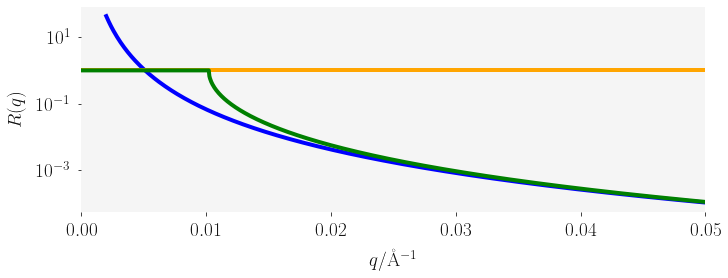

In [10]:
fig = plt.figure(constrained_layout=True, figsize=(10, 7.5/2))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
ax3 = fig.add_subplot(spec[0, :])

q2 = np.linspace(0, 0.05, 1000)
ax3.plot(q, r, c=list(_fig_params.TABLEAU)[0])
layers = np.array([[0, 0, 0, 0, 0], [0, 2.074, 0, 0, 0]])
ax3.plot(q2, abeles(q2, layers), c=list(_fig_params.TABLEAU)[2], zorder=10)
ax3.axhline(1, c=list(_fig_params.TABLEAU)[1])
ax3.set_yscale('log')
ax3.set_xlabel(r"$q$/Å$^{-1}$")
ax3.set_ylabel(r"$R(q)$")
ax3.set_xlim(0, 0.05)

plt.savefig('dyna.pdf')

In [11]:
plt.close()

In [12]:
from scipy.optimize import curve_fit

In [13]:
def abeles_build(q, thick, sld1, sld2):
    return abeles(q, np.array([[0, 0, 0, 0, 0], [thick, sld1, 0, 0, 0], [0, sld2, 0, 0, 0]]))

In [14]:
q2 = np.logspace(-3, -0.5, 40)

In [15]:
r = abeles(q2, np.array([[0, 0, 0, 0, 0], [40, 6.335, 0, 0, 0], [0, 2.074, 0, 0, 0]]))
r += np.abs((np.random.random((q2.size)) - 0.5) * q2 * r)
dr = np.abs(1/r) * 1e-9

In [16]:
popt, pcov = curve_fit(abeles_build, q2, r, sigma=dr, p0=[40, 6.335, 2.074])

In [17]:
popt

array([26.40148191,  8.98232713,  2.07585462])

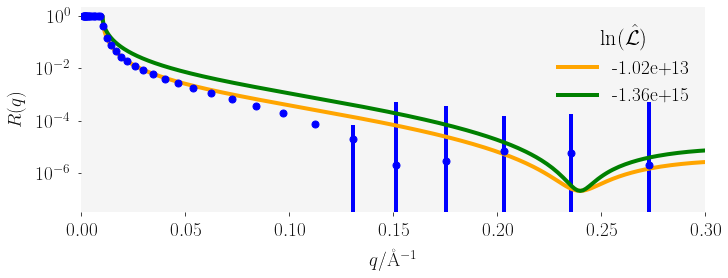

In [18]:
fig = plt.figure(constrained_layout=True, figsize=(10, 7.5/2))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
ax3 = fig.add_subplot(spec[0, :])
q3 = np.logspace(-3, -0.5, 1000)

rr = np.random.randn(len(popt)) * 10
rr[-1] = 0

rm = abeles_build(q2, *popt)
rm2 = abeles_build(q2, *(np.array(popt) + rr))
Lm = -0.5 * np.sum(np.square((r-rm)/dr) + np.log(2 * np.pi * dr))
Lm2 = -0.5 * np.sum(np.square((r-rm2)/dr) + np.log(2 * np.pi * dr))

rm = abeles_build(q3, *popt)
rm2 = abeles_build(q3, *(np.array(popt) + rr))

ax3.errorbar(q2, r, dr, c=list(_fig_params.TABLEAU)[0], zorder=10, marker='o', ls='')
ax3.plot(q3, rm, c=list(_fig_params.TABLEAU)[1], zorder=10, label='{:.2e}'.format(Lm))
ax3.plot(q3, rm2, c=list(_fig_params.TABLEAU)[2], zorder=10, label='{:.2e}'.format(Lm2))

ax3.set_yscale('log')
ax3.set_xlabel(r"$q$/Å$^{-1}$")
ax3.set_ylabel(r"$R(q)$")
ax3.legend(title=r'$\ln(\hat{\mathcal{L}})$', title_fontsize=22)
ax3.set_xlim(0, 0.3)

plt.savefig('likelihood.pdf')

In [19]:
def mut(p, b, km):
    m = np.zeros_like(p)
    R = np.random.randint(p.shape[1], size=(2, p.shape[1]))
    for j in range(p.shape[1]):
        m[:, j] = b + km * (p[:, R[0, j]] - p[:, R[1, j]])
    return m

In [20]:
def recomb(p, m, kr):
    o = np.array(p)
    rand = np.random.rand(p.shape[0], p.shape[1])
    o[rand < kr] = m[rand < kr]
    return o

In [21]:
def sel(p, o, f):
    new_p = np.array(p)
    for j in range(p.shape[1]):
        p_fom = f(p[:, j])
        o_fom = f(o[:, j])
        if o_fom > p_fom:
            new_p[:, j] = o[:, j]
    return new_p

In [22]:
def differential_evolution(population, f, km, kr, bounds, max_iter):
    history = np.array([population])
    best = population[:, np.argmin(f(population))]
    i = 0
    while i < max_iter:
        mutant = mut(population, best, km)
        offspring = recomb(population, mutant, kr)
        offspring[
            np.where(offspring >= bounds[1])
            or np.where(offspring < bounds[0])
        ] = np.random.uniform(bounds[0], bounds[1], 1)
        selected = sel(population, offspring, f)
        history = np.append(history, selected)
        history = np.reshape(
            history, (i + 2, population.shape[0], population.shape[1])
        )
        population = np.array(selected)
        best = population[:, np.argmin(f(population))]
        i += 1
    return history

In [23]:
startx1 = np.random.uniform(-40, 40, 8)
startx2 = np.random.uniform(-40, 40, 8)

In [24]:
def ackley(x):
    a = 20
    b = 0.2
    c = 2 * np.pi
    first = -a * np.exp(
        -b * np.sqrt(1 / 2 * np.sum(np.square(x), axis=0))
    )
    second = np.exp(1 / 2 * np.sum(np.cos(c * x), axis=0))
    return -1 * (first - second + a + np.exp(1))

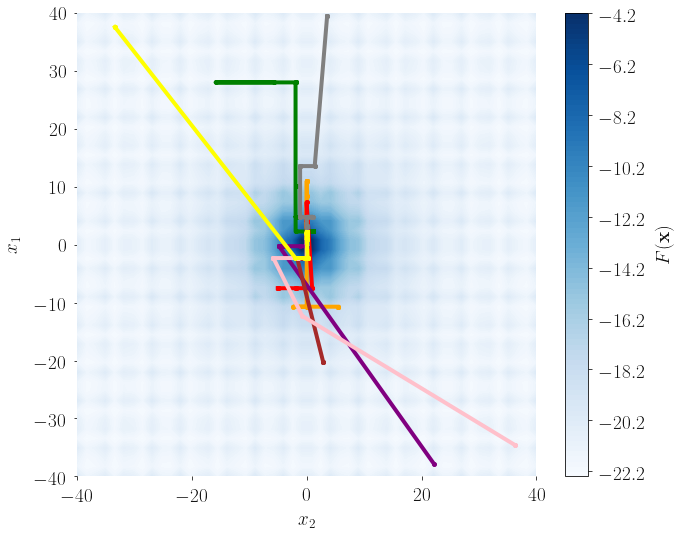

In [25]:
route = differential_evolution(
    np.array([startx1, startx2]),
    ackley,
    0.5,
    0.5,
    [-40, 40],
    100,
)

xs = np.linspace(-40.0, 40.0, 50)
ys = np.linspace(-40.0, 40.0, 50)
es = np.zeros((xs.size, ys.size))
for i in range(xs.size):
    for j in range(ys.size):
        es[i, j] = ackley(np.array([xs[i], ys[j]]))

fig = plt.figure(figsize=(10, 3.304*2.421))
ax = fig.add_subplot(111)
im = ax.contourf(ys, xs, es, 100, cmap="Blues")
for i in range(route.shape[2]):
    ax.plot(
        route[:, 0, i],
        route[:, 1, i],
        marker="o",
        ms=4,
        c=list(_fig_params.TABLEAU)[i + 1],
    )
ax.set_ylabel(r"$x_1$")
ax.set_xlabel(r"$x_2$")
plt.colorbar(im, label=r"$F(\mathbf{x})$")

plt.tight_layout()
plt.savefig("ackley.pdf", bbox_inches='tight', pad_inches=0.1)
plt.show()

In [26]:
import emcee

In [27]:
from scipy.stats import norm
from scipy.optimize import curve_fit


def gaussianfit(x, a1, a2, b1, b2):
    return a1 * norm.pdf(x - b1) + a2 * norm.pdf(x - b2)


def gaussian(x, a1):
    return a1[0] * norm.pdf(x - a1[2]) + a1[1] * norm.pdf(x - a1[3])

In [28]:
x = np.linspace(-5, 8, 25)
y = gaussian(x, [0.5, 1, 3, 0]) + np.random.randn(
    25
) * 0.05 * gaussian(x, [0.5, 1, 3, 0])
dy = y * 0.2

popt, pcov = curve_fit(gaussianfit, x, y, sigma=dy, p0=[0.5, 1, 3, 0])

x2 = np.linspace(-5, 8, 2500)

theta1 = np.zeros((4))
guess1 = gaussian(x, popt)

In [29]:
def log_likelihood(theta, x, y, dy):
    model = gaussian(x, theta)
    sigma2 = dy ** 2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

In [30]:
pos = popt + 1e-4 * np.random.randn(32, 4)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=(x, y, dy))
sampler.run_mcmc(pos, 1000, progress=True);

100%|██████████| 1000/1000 [00:14<00:00, 70.22it/s]


In [31]:
history = sampler.get_chain(discard=100, thin=1, flat=True)

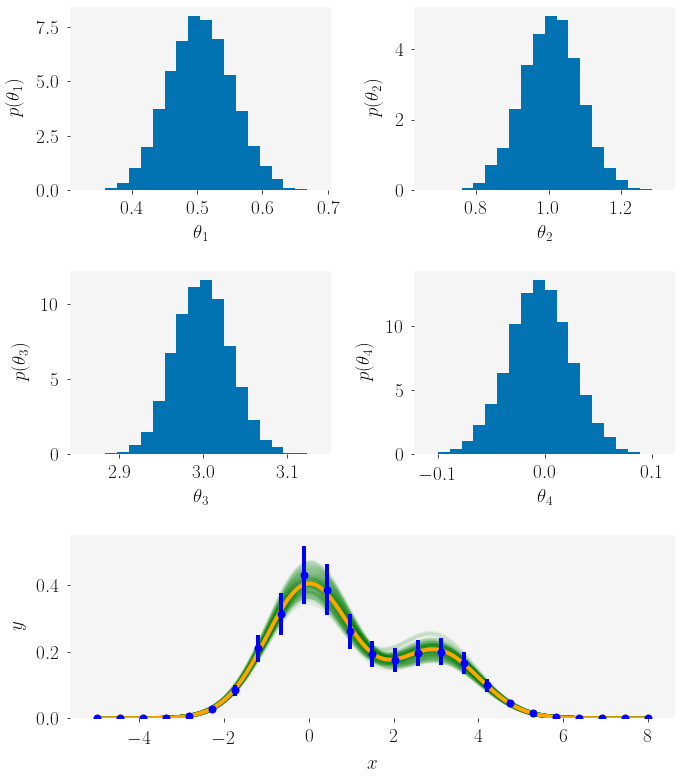

In [32]:
plt.figure(figsize=(10, 5.1625*2.2))
gs = gridspec.GridSpec(3, 2)

ax1 = plt.subplot(gs[2, :])
ax1.errorbar(
    x, y, marker="o", ls="", yerr=dy, c=list(_fig_params.TABLEAU)[0], zorder=10
)

choice = np.random.randint(low=0, high=history.shape[0], size=100)

for i in choice:
    ax1.plot(
        x2,
        gaussian(
            x2,
            [
                history[i, 0],
                history[i, 1],
                history[i, 2],
                history[i, 3],
            ],
        ),
        alpha=0.07,
        c=list(_fig_params.TABLEAU)[2],
    )

ax1.plot(x2, gaussian(x2, popt), c=list(_fig_params.TABLEAU)[1])

ax2 = plt.subplot(gs[0, 0])
ax2.hist(history[:, 0], bins=20, density=True, histtype="stepfilled")
ax3 = plt.subplot(gs[0, 1])
ax3.hist(history[:, 1], bins=20, density=True, histtype="stepfilled")
ax4 = plt.subplot(gs[1, 0])
ax4.hist(history[:, 2], bins=20, density=True, histtype="stepfilled")
ax5 = plt.subplot(gs[1, 1])
ax5.hist(history[:, 3], bins=20, density=True, histtype="stepfilled")
ax2.set_ylabel(r"$p(\theta_1)$")
ax3.set_ylabel(r"$p(\theta_2)$")
ax4.set_ylabel(r"$p(\theta_3)$")
ax5.set_ylabel(r"$p(\theta_4)$")
ax2.set_xlabel(r"$\theta_1$")
ax3.set_xlabel(r"$\theta_2$")
ax4.set_xlabel(r"$\theta_3$")
ax5.set_xlabel(r"$\theta_4$")
ax1.set_ylabel(r"$y$")
ax1.set_xlabel(r"$x$")
ax1.set_ylim(0, 0.55)

plt.tight_layout()
plt.savefig("mcmc.pdf", bbox_inches='tight', pad_inches=0.1)
plt.show()